In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import locale
locale.setlocale(locale.LC_MONETARY, 'en_IN')
format_currency = lambda x: locale.currency(x, grouping=True)

from IPython.display import display, HTML

css = """
<style>
    .jp-Notebook .jp-Cell {
        margin-bottom: 16px !important;
    }
</style>
"""

display(HTML(css))

In [2]:
df = pd.read_csv("data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589 entries, 0 to 588
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InvoiceNo    589 non-null    int64 
 1   Description  589 non-null    object
 2   Size         439 non-null    object
 3   Quantity     589 non-null    int64 
 4   UnitPrice    589 non-null    int64 
 5   PaymentMode  589 non-null    object
 6   PaymentDate  589 non-null    object
 7   PaymentTime  589 non-null    object
dtypes: int64(3), object(5)
memory usage: 36.9+ KB


In [4]:
# data cleaning and feature engineering

final_df = df.copy()

# combining date and time to create datetime
final_df["PaymentDateTime"] = pd.to_datetime(final_df["PaymentDate"] + " " + final_df["PaymentTime"])
final_df = final_df.drop(columns=["PaymentDate", "PaymentTime"])

# replacing some stuff in description (got this while looking at description values)
# edited froms source spreadsheet
"""
final_df["Description"] = final_df["Description"].str.replace("1 Year", "Baby")
final_df["Description"] = final_df["Description"].str.replace("Peti Coat", "Petticoat")
final_df["Description"] = final_df["Description"].str.replace("Purple White", "Purple")
final_df["Description"] = final_df["Description"].str.replace("Bed Sheet", "Bedsheet")
final_df["Description"] = final_df["Description"].str.replace("Half Pants", "Half Pant")
final_df["Description"] = final_df["Description"].str.replace("Track Pants", "Track Pant")
final_df["Description"] = final_df["Description"].str.replace("Pants", "Pant")
final_df["Description"] = final_df["Description"].str.replace("Shirt + Jeans", "Shirt + Jeans Set")
final_df["Description"] = final_df["Description"].str.replace("T-Shirt + Track Pant", "T-Shirt + Track Pant Set")
"""

final_df

,InvoiceNo,Description,Size,Quantity,UnitPrice,PaymentMode,PaymentDateTime
0,1,Dark Green Half Sleeves Polo Mens T-Shirt,XL,1,400,Online,2025-03-25 12:31:00
1,1,Blue Faded Mens Jeans,30,1,900,Online,2025-03-25 12:31:00
2,2,Gamcha Bath Towel,90,1,140,Cash,2025-03-25 15:30:00
3,3,Macho V Cut Mens Underwear,90,1,125,Online,2025-03-25 16:13:00
4,4,Rectangle Mosquito Net,6x6,1,150,Cash,2025-03-25 13:00:00
...,...,...,...,...,...,...,...
584,399,Sando Mens Vest,XL,1,260,Online,2025-04-26 21:13:00
585,399,Macho V Cut Mens Underwear,100,1,100,Online,2025-04-26 21:13:00
586,399,Pooja Brand Ladies Bra,38,1,140,Online,2025-04-26 21:13:00
587,399,Boxer Cotton Half Pant,XXL,1,180,Online,2025-04-26 21:13:00


```python
set([row for _, row in final_df["Description"].items()])
```

fields to create from Description
got this by individually looking into each description, also in future while adding data keep these
in mind while adding them
also can be updated by filtering with date and seeing what changes in new additions of data

1. Colour field

Black, Blue, Dark Green, Chocolate, Grey, Purple White, White, Red

2. Category field

Socks, Belt, Dungarees, Frock, Mask, Towel, Bed Sheet, Bedsheet, T-Shirt, Shirt, Track Pant, Handkerchief, Half Pants,
Half Pant, Shirt + Jeans Set, T-Shirt + Track Pant Set, Cap, Jeans, Kurta, Polo, Panties, Pants, Pant, Leggings,
Underwear, Hand Gloves, Cap, Dupatta, Blouse, Bra, Bra and Panties Set, Nighties, Pant, Kurti, Night Dress, Patiala Set,
Petticoat, Stoles, Three Piece Suit Set, Blanket, Vest, Wallet, Baby Clothes Set, Petticoat, Pillow Cover, Lungi, 
Mosquito Net, Saree, Sindoor

for set products -> use set as category and explain stuff in product details  
also cases like "Jeans Mens Shirt" => so always choose the last which is "Shirt"
solved these with multiple category matching

3. Company field

Adidas, Ajanta, Cotton Candy, ESSA, Eco Brand, Evo, Foggy, Gem, Lux Cozi, Lux Venus, Macho, Nike,
Selsia, Selsia 3 Set, Speed, Stant Best Shot, Stant Neu

4. Product details field

getting these by removing all the stuff from other fields

5. Gender field

Ladies, Girl -> Ladies  
Mens, Men, Boy -> Male  

if no mention of Ladies or Child then for these categories add male and Mens below to it:  
(based on assumption that these are mostly sold to mens as being there to shop and sold
stuff and thus assumed those with details are mostly mens, even if there are ladies they
are in small proportion)  
this is after applying all the fields

- T-Shirt
- Shirt
- Track Pant, Track Pants
- Half Pant, Half Pants
- Jeans
- Pants, Pant
- Lungi

also some of entries don't have Ladies like Lycra Leggings or Blouse Piece or stuff -> so add those to ladies  
Categories are:

- Leggings
- Petticoat
- Blouse
- Saree

6. Age field (not exact age but class name of each group)

Girl -> Girl  
Boy -> Boy  
Ladies -> Ladies  
Mens, Men -> Mens  
Baby -> Baby  
Child, Kids, Little -> Kids

In [5]:
def description_feature_engineering(desc_string):
    # first colour of product
    colors = ["Black", "Blue", "Dark Green", "Brown", "Grey", "Purple", "White", "Red"]
    matched_color = None
    for color in colors:
        if color in desc_string:
            matched_color = color
            desc_string = desc_string.replace(matched_color, "")
            break

    # gender and age group
    matched_gender = None
    matched_agegroup = None
    if "Girl" in desc_string:
        matched_gender = "Female"
        matched_agegroup = "Girl"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Ladies" in desc_string:
        matched_gender = "Female"
        matched_agegroup = "Ladies"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Boy" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Boy"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Mens" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Mens"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Men" in desc_string:
        matched_gender = "Male"
        matched_agegroup = "Mens"
        desc_string = desc_string.replace(matched_agegroup, "")

    if "Baby" in desc_string:
        matched_agegroup = "Baby"
        desc_string = desc_string.replace(matched_agegroup, "")
    elif "Child" in desc_string or "Kids" in desc_string or "Little" in desc_string:
        matched_agegroup = "Kids"
        desc_string = desc_string.replace(matched_agegroup, "")

    # company string
    companies = ["Adidas", "Ajanta", "Cotton Candy", "ESSA", "Eco Brand", "Evo",
                 "Foggy", "Gem", "Lux Cozi", "Lux Venus", "Macho", "Nike", "Selsia",
                 "Speed", "Stant", "Pooja Brand"]
    matched_company = None
    for company in companies:
        if company in desc_string:
            matched_company = company
            desc_string = desc_string.replace(matched_company, "")
            break

    # category field
    categories = [
        "Handkerchief", "Socks", "Belt", "Cap", "Dungarees", "Frock", "Mask", "Towel", "Bedsheet",
        "T-Shirt", "Shirt", "Track Pant", "Half Pant", "Pant", "Jeans", "Kurta", "Panties",
         "Leggings", "Plazo", "Underwear", "Inner Slips", "Hand Gloves", "Dupatta", "Blouse", "Bra", "Nighties",
         "Kurti", "Night Dress", "Petticoat", "Stoles", "Blanket", "Vest", "Wallet", "Pillow Cover", "Lungi",
         "Mosquito Net", "Saree", "Sindoor", "Set"
    ]
    matched_category = None
    matched_categories = []  # list as we have to handle more than one case
    for category in categories:
        if category in desc_string:
            matched_categories.append(category)

    if len(matched_categories) == 1:
        matched_category = matched_categories[0]
        desc_string = desc_string.replace(matched_categories[0], "")
    elif len(matched_categories) == 2:
        if "Set" in matched_categories:
            matched_category = "Set"
            desc_string = desc_string.replace(matched_category, "")
        elif "Jeans" in matched_categories and "Shirt" in matched_categories:
            matched_category = "Shirt"
            desc_string = desc_string.replace(matched_category, "")
        else:
            # handling cases like "T-Shirt" both Shirt and T-Shirt is matched
            # same for Pant and Panties
            bigger_cate = None
            smll_cate = None
            if len(matched_categories[0]) > len(matched_categories[1]):
                bigger_cate = matched_categories[0]
                smll_cate = matched_categories[1]
            else:
                bigger_cate = matched_categories[1]
                smll_cate = matched_categories[0]

            if smll_cate in bigger_cate:
                matched_category = bigger_cate
                desc_string = desc_string.replace(matched_category, "")
    elif len(matched_categories) > 2:
        if "Set" in matched_categories:
            matched_category = "Set"
            desc_string = desc_string.replace(matched_category, "")

    # details
    cleaned_details = ' '.join(desc_string.split())

    return [matched_color, matched_category, matched_company, cleaned_details, matched_gender, matched_agegroup]


features_df = final_df['Description'].apply(description_feature_engineering).apply(pd.Series)
features_df.columns = [
    "Product_Color", "Product_Category", "Product_Company", "Product_Details", "Product_Gender", "Product_AgeGroup"
]
final_df = pd.concat([final_df, features_df], axis=1)

In [6]:
# sanity check
# final_df[final_df["Product_Category"] == ""]
final_df[final_df["Product_Category"].isna()]

,InvoiceNo,Description,Size,Quantity,UnitPrice,PaymentMode,PaymentDateTime,Product_Color,Product_Category,Product_Company,Product_Details,Product_Gender,Product_AgeGroup


In [7]:
final_df[final_df["Product_Category"] == "Track Pant"]["Description"].unique()

array(['Blue Nylon Track Pant', 'Nylon Track Pant', 'Track Pant',
       'Eco Brand Child Track Pant'], dtype=object)

In [8]:
# last gender add to those which didn't have gender mentioned in description
# I am assuming that most of the customer of our business is from Mens, so with it
# i am adding those fields. Here i am less confident with T-Shirt and Jeans as there
# are ladies version in our shop but again above assumption based upon me selling few stuff
# in shop

male_categories = ["T-Shirt", "Shirt", "Track Pant", "Half Pant", "Pant", "Jeans", "Lungi"]
final_df.loc[
    (final_df["Product_Category"].isin(male_categories)) &
    (final_df["Product_Gender"].isna()), "Product_Gender"
] = "Male"

final_df.loc[
    (final_df["Product_Category"].isin(male_categories)) &
    (final_df["Product_AgeGroup"].isna()), "Product_AgeGroup"
] = "Mens"

In [9]:
# here i don't really have to assume as these refers to Ladies section

female_categories = ["Leggings", "Petticoat", "Blouse", "Saree"]
final_df.loc[
    (final_df["Product_Category"].isin(female_categories)) &
    (final_df["Product_Gender"].isna()), "Product_Gender"
] = "Female"

final_df.loc[
    (final_df["Product_Category"].isin(female_categories)) &
    (final_df["Product_AgeGroup"].isna()), "Product_AgeGroup"
] = "Ladies"

In [10]:
# lastly the totalprice of each product and sorting according to datetiem

final_df["TotalPrice"] = final_df["Quantity"] * final_df["UnitPrice"]
final_df = final_df.sort_values(by="PaymentDateTime")

In [11]:
temp_df = final_df[["Product_Company", "Product_Details"]].fillna("")
temp_df = temp_df["Product_Company"] + " " + temp_df["Product_Details"]
final_df["Product_CD"] = temp_df.str.strip()

Question to answer:

Question i would like analysis to answer:
1. Daily revenue plot with each week colored to identify pattern in week
2. Weekly box plot of revenue, quantity and invoice number sold to understand distribution of sales across week

Does weekly box plot for all three vary depending upon seasonality like summer, monsoon, etc. It is like variation between general and specific case where general can give me some measure with some confidence like in below histogram of time plot for all days i can confidently say that around 6 PM there are customer. Now this is confidence but accuracy can be low like around 4 PM there are customer but in Sunday there is more probability of customer occuring than any other day.

This highlights the general and specific case where all are govern by number of data points i have. Like if i create box plot for Sunday Revenue, if i don't really segregate according to what month it is like April or May. Then it will give overall statistics. But if i separate and visualize each then there is confidence on the month as i have alot of data for that month. So there can be variation between two plots

3. Which category of products sold the most and revenue wise. Colour it with gender or age group

Here there are two types of products one is high premium which is for small quantity have high revenue
No it doesn't make sense as most of the product quantity aggregation wont help us identify premium products as above aggregation wont make sense
Premium products can only be distinguished by big unit price
So segregate top products into big premium products and those not

4. Also look at the number of transactions per day, week, etc and see if there's any pattern or trend
5. Is there any product category which is being sold each day
6. Is there grouping of products where customers buy one product with other
7. Time when there is huge customer incoming and which we have served as only served customer data is available
8. Do worker labours dominate our customer base
9. When do they come and which day
10. Distribution between online and cash payment customer
11. Distribution of product sales with time, day and week
12. For top products see distribution of details and if company or gender matters or not
13. Order Value, distribution between small and big orders in a day
14. Distribution of time, day, etc over most revenue or quantity sold
15. Distribution of premium products over time

Meaning when a premium product has been sold

16. Distribution of size per product category
17. Distribution of product details and company over category and time
18. Unit price vs Quantity
19. Distribution of unit price over category and time
20. Distribution of size over category, unit price, quantity and time
21. Lowest a product went to and distribution of it with quantity and product description time, number of product in transaction

One of the main insights is that we serve alot of worker labours in clothing store
So more than one customer can come and pay at single time for all of them
So keep this in mind while analysing
Also this reflects that as a data gatherer i need to have some kind of experience about that data
For example, here i stood in the store and sold some products and that's why i was able to mention the above stuff

Also if i am using any assumption write it down there, and explain why i have this assumption. Have some good basis for the assumption.

Also write the meta data markdown file where most of it are assumption.

In [ ]:
# daily revenue plot with each week coloured to identify pattern

dailyrev = final_df.groupby(final_df["PaymentDateTime"].dt.date).agg(
    TotalRevenue=("TotalPrice", "sum"),
    TotalQuantity=("Quantity", "sum"),
    WeekNum=("PaymentDateTime", lambda x: x.dt.isocalendar().week.iloc[0])
)
dailyrev = dailyrev.reset_index()
dailyrev["DayName"] = dailyrev['PaymentDateTime'].apply(lambda x: x.strftime("%a"))

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta']

# Plot the line
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(dailyrev["PaymentDateTime"], dailyrev["TotalRevenue"], color="black",
        marker="X", mfc="red", label="Daily Revenue")

for _, row in dailyrev.iterrows():
    plt.text(row["PaymentDateTime"], row["TotalRevenue"] + 500, s=row["DayName"])


for i, (week, group) in enumerate(dailyrev.groupby("WeekNum")):
    start_date = group["PaymentDateTime"].min()
    end_date = group["PaymentDateTime"].max()
    ax.axvspan(start_date, end_date, color=colors[i % len(colors)], alpha=0.2, label=f"Week {week}")


# Optional: improve formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %y'))
plt.xticks(rotation=45)
plt.ylabel("Revenue")
plt.title("Daily Revenue with Weekly Colored Regions")
plt.tight_layout()
plt.show()

In [ ]:
dailyrev.groupby("WeekNum")["TotalRevenue"].sum().plot(kind="bar")

plt.grid(axis="y", alpha=0.5)
plt.title("Weekly Revenue")
plt.xlabel("Weeks")
plt.ylabel("Revenue")

plt.tight_layout()

plt.show()

In [ ]:
weekrev = final_df.groupby(final_df["PaymentDateTime"].dt.date).agg(
    TotalRevenue=("TotalPrice", "sum"),
    TotalQuantity=("Quantity", "sum"),
    TotalInvoices=("InvoiceNo", "nunique"),
    WeekNum=("PaymentDateTime", lambda x: x.dt.isocalendar().week.iloc[0])
)
weekrev = weekrev.reset_index()
weekrev["DayName"] = weekrev["PaymentDateTime"].apply(lambda x: x.strftime("%A"))

# Ensure DayName is ordered correctly
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekrev['DayName'] = pd.Categorical(weekrev['DayName'], categories=days_order, ordered=True)

# Plot boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=weekrev, x='DayName', y='TotalRevenue')

plt.title("Boxplot with Quartile and Whisker Labels")
plt.ylabel("Total Revenue per Day")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.tight_layout()

plt.show()

In [31]:
dailyrev[["TotalRevenue", "TotalQuantity"]].corr()

,TotalRevenue,TotalQuantity
TotalRevenue,1.00000,0.94099
TotalQuantity,0.94099,1.00000


In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=weekrev, x='DayName', y='TotalQuantity')

plt.title("Boxplot with Quartile and Whisker Labels")
plt.ylabel("Total Quantity per Day")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.tight_layout()

plt.show()

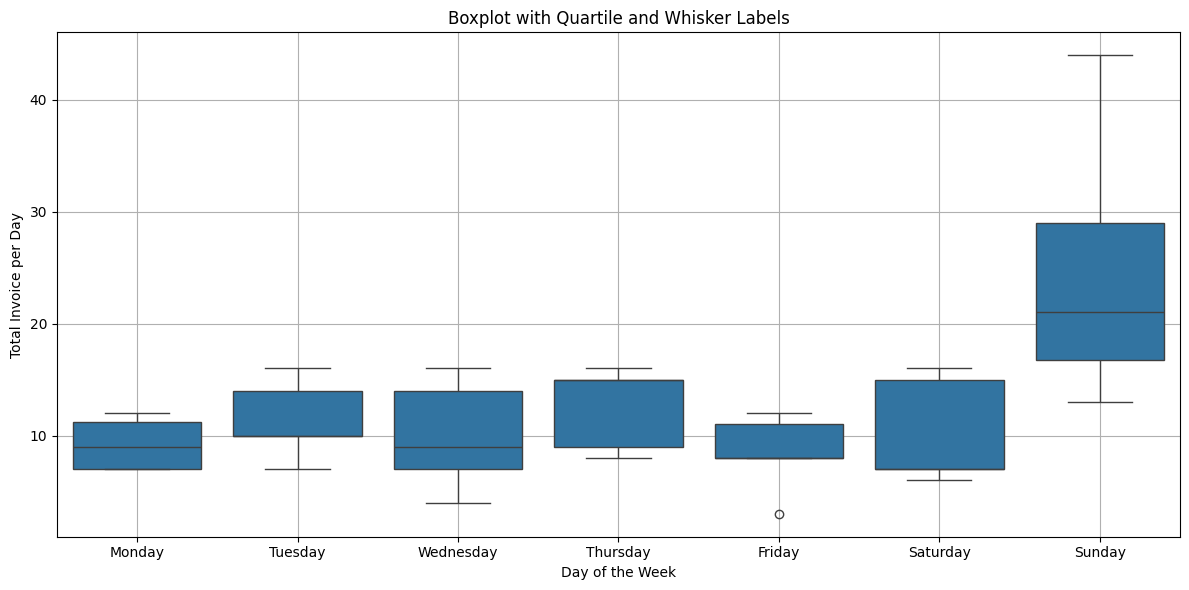

In [22]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=weekrev, x='DayName', y='TotalInvoices')

plt.title("Boxplot with Quartile and Whisker Labels")
plt.ylabel("Total Invoice per Day")
plt.xlabel("Day of the Week")
plt.grid(True)
plt.tight_layout()
plt.show()

From looking at above plot, Sunday is clear winner where this is the day with highest revenue generated.

Also Monday the day after Sunday has least revenue compared to rest of the days. Thursday and Saturday pickup where Saturday sales are high compared to rest except Sunday. This means that alot of customer are served during weekends.

Still i have around 4 to 5 data points as only 1 month has been passed. So collect more to come to a decision. Also does this thing vary depending upon seasonality like in summer or winter?

In [ ]:
# let's look at distribution of customer with respect to time

# AM/PM labels for 24-hour time
am_pm_labels = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM',
                '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM',
                '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']

plt.figure(figsize=(12, 6))
sns.histplot(final_df["PaymentDateTime"].dt.hour, bins=24, kde=False)

# Set ticks and labels
plt.xticks(ticks=range(24), labels=am_pm_labels, rotation=45)
plt.xlabel("Time of Day")
plt.ylabel("Frequency")
plt.title("Histogram of Transactions by Hour (AM/PM)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

plt.show()

**Overall this says that any time here a customer can arrive. There is some confidence but it is not certain. To make it more accurate we need to separate it according to day wise and below that i have done it. So here we are having accuracy and including details tradeoff where above it is general and below one is specific**

The same thing can be commented upon variation of box plot with respect to seasons or any other period like summer, monsoon, etc.

In [ ]:
# let's look at distribution of customer with respect to time and day

daywise_df = final_df.copy()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daywise_df["DayName"] = daywise_df["PaymentDateTime"].apply(lambda x: x.strftime("%A"))
daywise_df["DayName"] = pd.Categorical(daywise_df['DayName'], categories=days_order, ordered=True)

daywise_df['Hour'] = daywise_df["PaymentDateTime"].dt.hour

# FacetGrid for 7 days, assuming df has 'day' and 'time' columns
g = sns.FacetGrid(daywise_df, col="DayName", col_wrap=4, sharex=True, sharey=True)
g.map(sns.histplot, "Hour", bins=24)

# Customize all axes
for ax in g.axes.flatten():
    # Hide y-ticks
    ax.set_yticks([])
    ax.set_ylabel("")

    # Format x-ticks in AM/PM
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)%12 or 12}{'AM' if x < 12 else 'PM'}"))

    # **Force showing x-tick labels even if not bottom row**
    ax.tick_params(axis='x', which='both', labelbottom=True, labelrotation=45)

# Clean up titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("", "")

plt.subplots_adjust(hspace=0.4)

plt.show()

In [ ]:
temp_df = final_df.copy()
temp_df["Product_Gender"] = temp_df["Product_Gender"].fillna("Neutral")

pivot_df = temp_df.pivot_table(
    index='Product_Category',
    columns='Product_Gender',
    values='TotalPrice',
    aggfunc='sum',
    fill_value=0
)

# Calculate total revenue and sort
pivot_df['Total_Revenue'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Total_Revenue', ascending=False)
pivot_df = pivot_df.drop(columns='Total_Revenue')  # Remove helper column for clean plot

ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6), width=0.8, colormap='Set2')

plt.title('Revenue by Product Category and Gender')
plt.xlabel('Product Category')
plt.ylabel('Revenue')
plt.legend(title='Product Gender')
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
pivot_df = temp_df.pivot_table(
    index='Product_Category',
    columns='Product_Gender',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)

pivot_df['Quantity'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='Quantity', ascending=False)
pivot_df = pivot_df.drop(columns='Quantity')

pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6), width=0.8, colormap='Set2')

plt.title('Quantity by Product Category and Gender')
plt.xlabel('Product Category')
plt.ylabel('Quantity')
plt.legend(title='Product Gender')
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

From above two graphs, it shows that even though Vest are sold more, it generates less revenue compared to T-Shirt or Shirt and it makes sense as for similar amount of product the unit price matters in Total Revenue. Since unit price in above two are more than Vest thus it generates a lot of revenue.

Here T-Shirt and Shirt couldn't compete with Underwear even though Unit Price is higher than most of the Underwear because the quantity ascept of underwear compensate for low unit price. The quantity is very large and thus even though unit price is above two are high due to small quantity compared to underwear. It couldn't come at top.

So here we are seeing how Unit Price and Quantity affects TotalPrice.

In [ ]:
category_df = final_df.groupby([final_df["PaymentDateTime"].dt.date, "Product_Category"])["Quantity"].sum().unstack().fillna(0)

# Sort products by total demand (sum across all dates)
sorted_products = category_df.sum().sort_values(ascending=False).index

# Sort dates chronologically
sorted_dates = category_df.sort_index().index

# Create sorted heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(category_df.loc[sorted_dates, sorted_products].T,  # Transpose and sort
            cmap='mako',
            annot=False,
            cbar_kws={'label': 'Quantity Sold'})
plt.title('Product Demand Heatmap (Sorted by Quantity Sold)')
plt.xlabel('Date')
plt.ylabel('Product Category')
plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [23]:
# checking out each category

product_df = final_df[final_df["Product_Category"] == "Underwear"].copy()
product_df["WeekDay"] = product_df["PaymentDateTime"].dt.day_name()
product_df.head()

,InvoiceNo,Description,Size,Quantity,UnitPrice,PaymentMode,PaymentDateTime,Product_Color,Product_Category,Product_Company,Product_Details,Product_Gender,Product_AgeGroup,TotalPrice,Product_CD,WeekDay
3,3,Macho V Cut Mens Underwear,90,1,125,Online,2025-03-25 16:13:00,None,Underwear,Macho,V Cut,Male,Mens,125,Macho V Cut,Tuesday
6,5,Speed Long Trunk Mens Underwear,85,1,120,Online,2025-03-25 18:37:00,None,Underwear,Speed,Long Trunk,Male,Mens,120,Speed Long Trunk,Tuesday
13,7,Speed Long Trunk Mens Underwear,85,1,80,Cash,2025-03-25 19:15:00,None,Underwear,Speed,Long Trunk,Male,Mens,80,Speed Long Trunk,Tuesday
10,7,Lux Cozi Mini Trunk Mens Underwear,85,1,120,Cash,2025-03-25 19:15:00,None,Underwear,Lux Cozi,Mini Trunk,Male,Mens,120,Lux Cozi Mini Trunk,Tuesday
22,14,Stant Printed Lycra Semi Long Mens Underwear,90,2,150,Cash,2025-03-26 21:45:00,None,Underwear,Stant,Printed Lycra Semi Long,Male,Mens,300,Stant Printed Lycra Semi Long,Wednesday


In [14]:
categories = ["Color", "Company", "Details", "Gender", "AgeGroup", "CD"]

for category in categories:
    print(f"{category}:", product_df[f"Product_{category}"].unique())

Color: [None]
Company: ['Macho' 'Speed' 'Lux Cozi' 'Stant' 'Gem' 'Lux Venus']
Details: ['V Cut' 'Long Trunk' 'Mini Trunk' 'Printed Lycra Semi Long']
Gender: ['Male']
AgeGroup: ['Mens']
CD: ['Macho V Cut' 'Speed Long Trunk' 'Lux Cozi Mini Trunk'
 'Stant Printed Lycra Semi Long' 'Stant Long Trunk' 'Macho Long Trunk'
 'Macho Mini Trunk' 'Speed Mini Trunk' 'Gem Long Trunk'
 'Lux Venus Long Trunk']


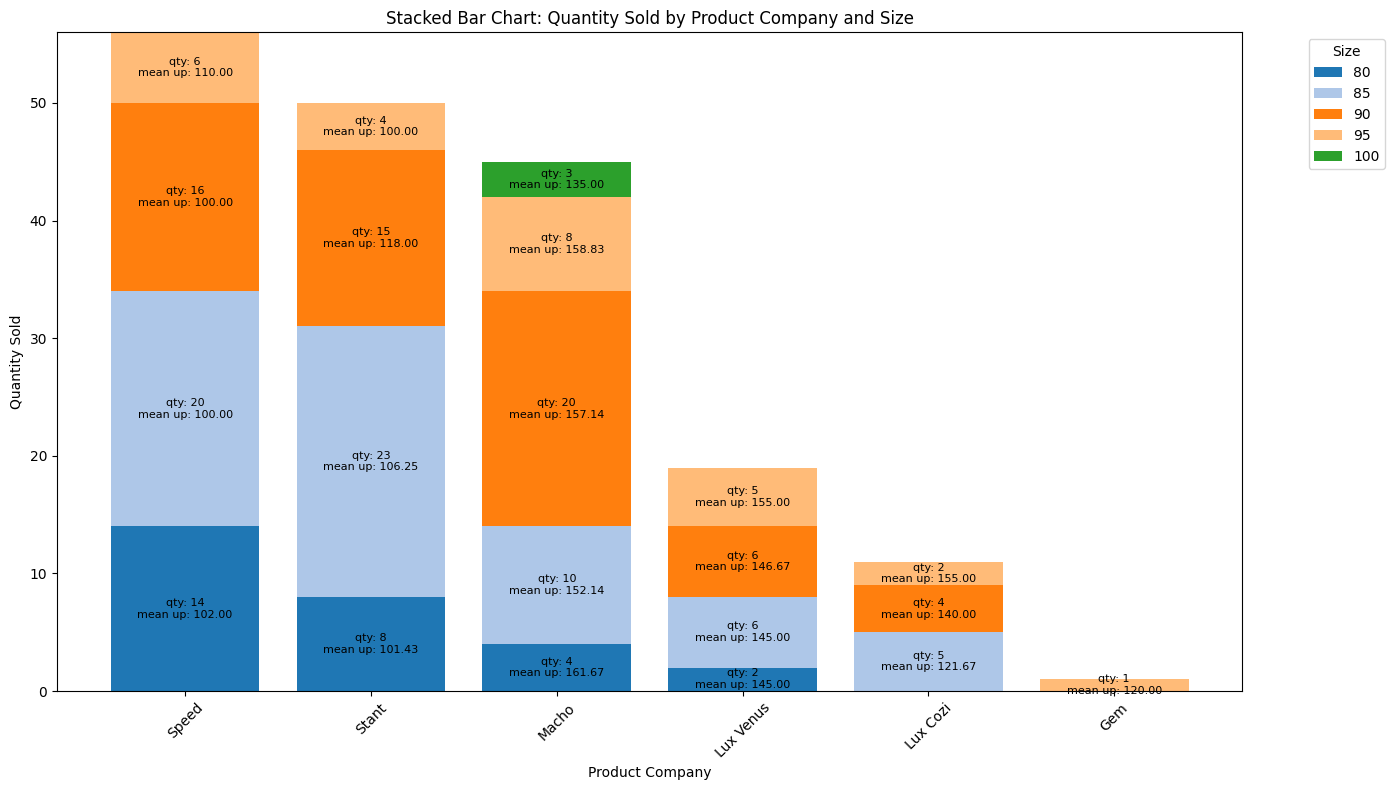

In [137]:
temp_df = product_df[~product_df["Size"].isna()].copy()
temp_df["Size"] = temp_df["Size"].astype(int)
grouped = temp_df.groupby(['Product_Company', 'Size']).agg(
    quantity_sold=('Quantity', 'sum'),
    unit_price_mean=('UnitPrice', 'mean')
).reset_index()

# Now pivot to wide format for stacking
pivot_quantity = grouped.pivot(index='Product_Company', columns='Size', values='quantity_sold').fillna(0)
pivot_quantity = pivot_quantity.loc[pivot_quantity.T.sum().sort_values(ascending=False).index]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))

# List of sizes for consistent color
size_order = sorted(temp_df['Size'].unique())

# Stacking bars manually
bottom = pd.Series([0]*pivot_quantity.shape[0], index=pivot_quantity.index)

colors = sns.color_palette('tab20', n_colors=len(size_order))

for idx, size in enumerate(size_order):
    heights = pivot_quantity[size] if size in pivot_quantity.columns else pd.Series([0]*pivot_quantity.shape[0], index=pivot_quantity.index)
    ax.bar(pivot_quantity.index, heights, bottom=bottom, color=colors[idx], label=size)

    # Add text
    for i, company in enumerate(pivot_quantity.index):
        qty = heights[company]
        if qty > 0:  # Only add text if there is some quantity
            # Find the matching unit price mean
            unit_price = grouped[
                (grouped['Product_Company'] == company) & (grouped['Size'] == size)
            ]['unit_price_mean'].values
            if len(unit_price) > 0:
                text = f"qty: {int(qty)}\nmean up: {unit_price[0]:.2f}"
                ax.text(
                    i, bottom[company] + qty/2, text,
                    ha='center', va='center', fontsize=8, color='black'
                )

    bottom += heights

ax.set_xlabel('Product Company')
ax.set_ylabel('Quantity Sold')
ax.set_title('Stacked Bar Chart: Quantity Sold by Product Company and Size')
ax.legend(title='Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

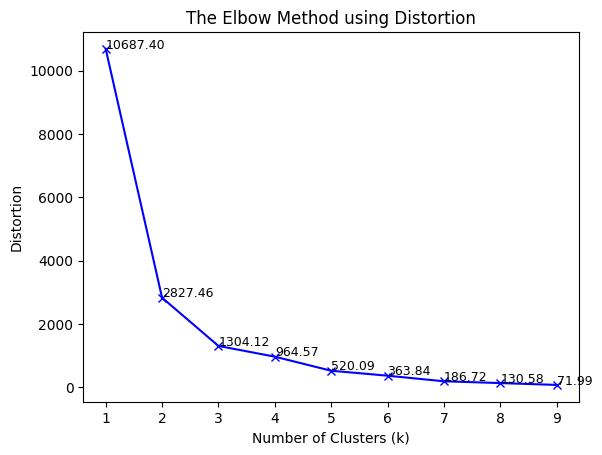

In [34]:
# let's cluster unitprice

# Reshape because KMeans expects 2D input
X = np.array(final_df[final_df["Product_Category"] == "Track Pant"]["UnitPrice"]).reshape(-1, 1)

distortions = []
mapping1 = {}
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    mapping1[k] = distortions[-1]


plt.plot(K, distortions, 'bx-')
for key, val in mapping1.items():
    plt.text(key, val + 20, s=f"{val:.2f}", fontsize=9)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [13]:
def get_knee(unit_prices, threshold=0.5):
    X = np.unique(unit_prices).reshape(-1, 1)
    distortions = {}

    max_possible_clusters = len(np.unique(unit_prices))

    for k in range(1, 10):
        if k > max_possible_clusters:
            # No point trying to cluster more than unique points
            break
        kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
        distortions[k] = kmeanModel.inertia_ / X.shape[0]

    ks = sorted(distortions.keys())
    distortion_values = [distortions[k] for k in ks]

    # Calculate % drops
    percentage_drops = []
    for i in range(1, len(distortion_values)):
        drop = (distortion_values[i-1] - distortion_values[i]) / distortion_values[i-1]
        percentage_drops.append(drop)

    # Find where the drop starts becoming small
    elbow_k = None
    for i, drop in enumerate(percentage_drops):
        if drop < threshold:
            elbow_k = ks[i]
            break

    if elbow_k is None:
        elbow_k = 1

    return elbow_k

In [89]:
get_knee(np.array(final_df[final_df["Product_Category"] == "Underwear"]["UnitPrice"]))

3

In [24]:
# k = 3 is good value for cluster
# k = 4 can be also but with domain knowledge i know that there are three types of underwear
# with those unit prices. And i think k = 4 because those middle ones are at lower price
# thus 120 rupees cluster is made

# Apply KMeans
X = np.array(product_df["UnitPrice"]).reshape(-1, 1)
kmeans = KMeans(n_clusters=3, random_state=42)
product_df["Clusters"] = kmeans.fit_predict(X)
product_df["Clusters"] = product_df["Clusters"].map(product_df.groupby("Clusters")["UnitPrice"].apply(lambda x: f"[{x.min()} - {x.max()}]").to_dict())

cluster_df = product_df.groupby(["Clusters", "Product_CD"])["Quantity"].sum()

"""
idx_val = product_df.groupby("Clusters")["UnitPrice"].median().apply(lambda x: str(x))
idx_val = product_df.groupby("Clusters")["UnitPrice"].apply(lambda x: f"[{x.min()} - {x.max()}]")
cluster_df.index = cluster_df.index.set_levels(
    cluster_df.index.levels[0].map(idx_val), level="Clusters"
)
"""

cluster_df = cluster_df.unstack().fillna(0)
cluster_df = cluster_df.loc[cluster_df.T.sum().sort_values(ascending=False).index].T  # sorting index
cluster_df.columns.name = None
cluster_df.head()

,[80 - 120],[125 - 160],[170 - 200]
Product_CD,,,
Gem Long Trunk,1.0,0.0,0.0
Lux Cozi Mini Trunk,3.0,8.0,0.0
Lux Venus Long Trunk,0.0,19.0,0.0
Macho Long Trunk,0.0,6.0,19.0
Macho Mini Trunk,0.0,7.0,0.0


In [ ]:
cluster_up = np.array(cluster_df.columns)
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(cluster_up))

colors = sns.color_palette('tab20', n_colors=len(cluster_df.index))
pcd_to_color = {pcd: col for col, pcd in zip(colors, cluster_df.index)}

for pcd, vals in cluster_df.iterrows():
    ax.bar(cluster_up, np.array(vals), width=0.5, label=pcd, color=pcd_to_color[pcd], bottom=bottom)

    # Add text
    for i, qty in enumerate(np.array(vals)):
        if qty > 0:
            ax.text(i, bottom[i] + qty/2, f"{pcd}: {int(qty)}", ha='center', va='center', fontsize=8, color='black')

    bottom += np.array(vals)

for i, total_qty in enumerate(np.array(cluster_df.sum())):
    ax.text(i, total_qty + 2, f"Total: {int(total_qty)}", ha='center', va='center', fontsize=10, color='black')

# ax.legend(title='Product Details', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Unit Price Cluster Center")
ax.set_ylabel("Quantity Sold")
ax.set_title("Distribution of Unit Price and Details")
plt.tight_layout()

plt.show()

In [101]:
product_df.groupby("Clusters").agg({
    "UnitPrice": ["mean", "median", "count", lambda x: set(x)]
})

UnitPrice                                                       
                mean median count                                <lambda_0>
Clusters                                                                   
0         182.307692  180.0    13            {200, 170, 175, 180, 185, 190}
1         100.133333  100.0    75                        {120, 90, 80, 100}
2         144.714286  150.0    42  {160, 130, 135, 140, 143, 150, 155, 125}

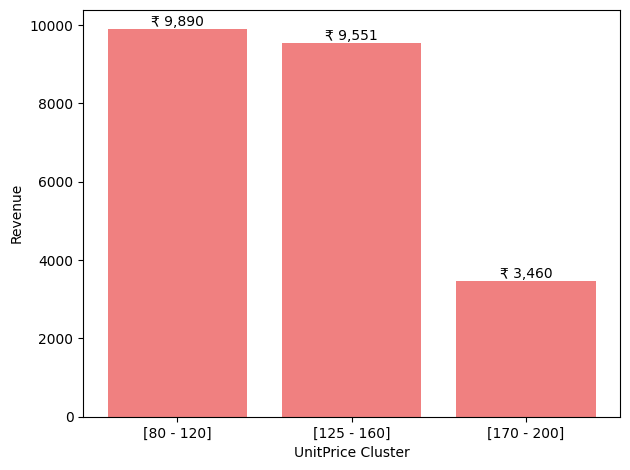

In [106]:
price_cluster = product_df.groupby("Clusters")['TotalPrice'].sum().sort_values(ascending=False)

fig, ax = plt.subplots()
bars = ax.bar(price_cluster.index, height=price_cluster, color='lightcoral')

values = np.array(price_cluster)
ax.bar_label(p, labels=[f'₹ {v:,}' for v in values])

plt.xlabel("UnitPrice Cluster")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

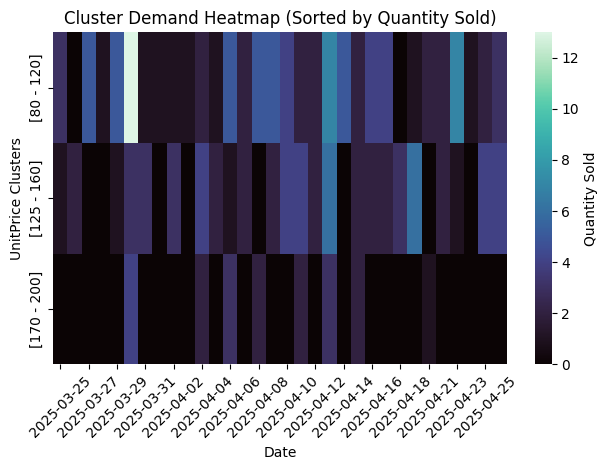

In [37]:
cluster_time_df = product_df.groupby([product_df["PaymentDateTime"].dt.date, "Clusters"])["Quantity"].sum().unstack().fillna(0)

# Sort products by total demand (sum across all dates)
sorted_products = cluster_time_df.sum().sort_values(ascending=False).index

# Sort dates chronologically
sorted_dates = cluster_time_df.sort_index().index

# Create sorted heatmap
# plt.figure(figsize=(12, 8))
sns.heatmap(cluster_time_df.loc[sorted_dates, sorted_products].T,  # Transpose and sort
            cmap='mako',
            annot=False,
            cbar_kws={'label': 'Quantity Sold'})
plt.title('Cluster Demand Heatmap (Sorted by Quantity Sold)')
plt.xlabel('Date')
plt.ylabel('UnitPrice Clusters')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

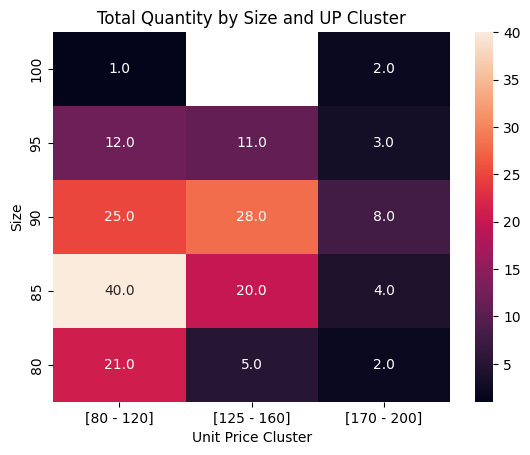

In [65]:
# let's check if there is underlying pattern between unit price and size

# Size-price matrix
size_price = product_df.pivot_table(index='Size', columns='Clusters', values='Quantity', aggfunc='sum')
size_price = size_price.loc[
    size_price.index.astype(int).sort_values(ascending=False).astype(str),
    size_price.sum().sort_values(ascending=False).index
]

sns.heatmap(size_price, annot=True, fmt=".1f")

plt.xlabel("Unit Price Cluster")
plt.title('Total Quantity by Size and UP Cluster')

plt.show()

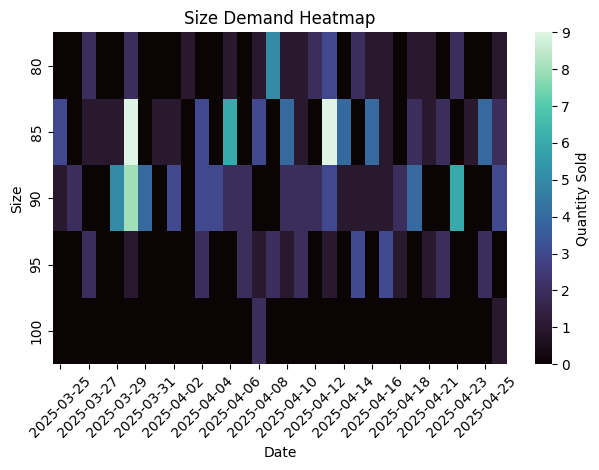

In [78]:
size_time_df = product_df.groupby([product_df["PaymentDateTime"].dt.date, "Size"])["Quantity"].sum().unstack().fillna(0)
size_time_df = size_time_df.loc[
    size_time_df.sort_index().index,
    pd.Series(size_time_df.columns).astype(int).sort_values().astype(str)
]

# Create sorted heatmap
sns.heatmap(
    size_time_df.T,
    cmap='mako',
    annot=False,
    cbar_kws={'label': 'Quantity Sold'}
)

plt.title('Size Demand Heatmap')
plt.xlabel('Date')
plt.ylabel('Size')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**From this i can understand that in underwear most of the sales come from 85 and 90 size underwear where 85 dominates in unit price range 80 - 120 and 90 dominate in rest. Also you can see normal distribution in Size vs UP Cluster for each cluster. I don't know if this is noise or pattern where person buying lower unit price underwear have underwear size most probably 85 but i need more data to check statistically.**

**But there are also cases where i didn't have certain size in that unit price which the customer wanted so i needed to upsell to bigger unit price. Where some cases customer go with purchase but some cases they don't. Let's identify need of customer to certain size and unit price. But how do i do that?**

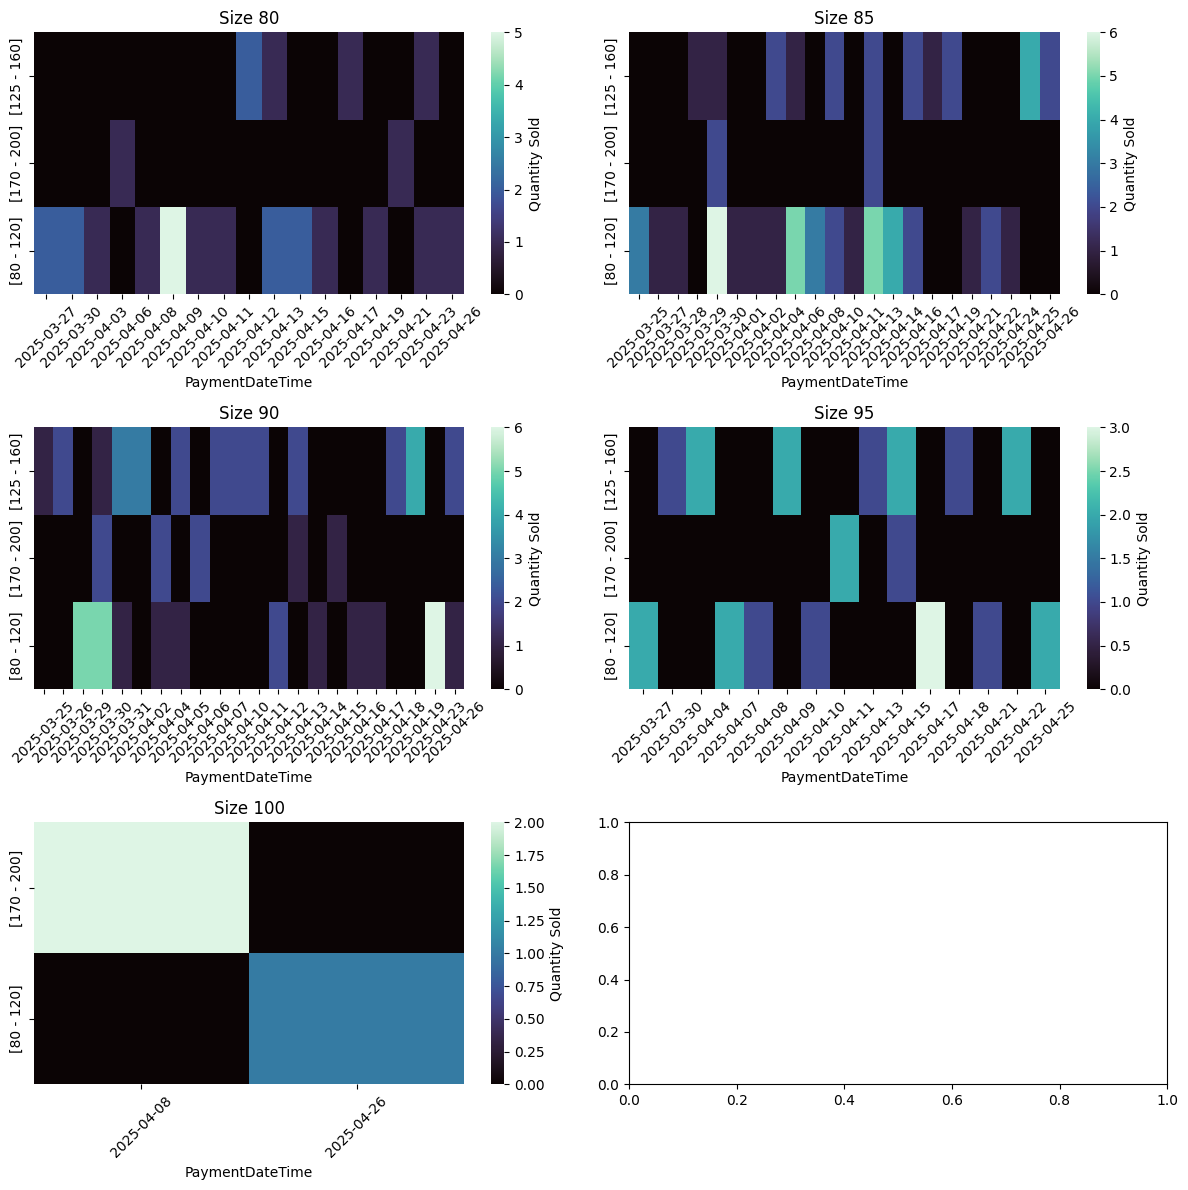

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, size in enumerate(["80", "85", "90", "95", "100"]):
    ax = axes[i // 2, i % 2]
    k = product_df[product_df["Size"] == size]
    k = k.groupby([k["PaymentDateTime"].dt.date, k["Clusters"]])["Quantity"].sum().unstack().fillna(0)
    k.columns = np.array(k.columns)
    sns.heatmap(k.T, cmap="mako", annot=False, cbar_kws={'label': "Quantity Sold"}, ax=ax)
    ax.set_title(f'Size {size}')
    ax.tick_params(axis='x', rotation=45)


plt.tight_layout()
plt.show()

From above and another extra information which is when father went to buy new stocks which is (28th March 2025). I can conclude that these periods when the size of that cluster didn't sold and then sold doesn't indicate there were no stocks. There were but they didn't sold out. Here i can't comment upon Size = 85 during end as i was in the shop and upselled to higher unit price product because \[80 - 120\] was not present.

Also about 170 to 200 cluster, i can comment that they didn't sold out not due to stock deficiency. I checked out the stocks for macho products.

In [83]:
# now to understand the maximum price lowered where max value of unit price is considered as selling price
# here there is problem, certain products needs to be segregated according to unit price which is not case
# in underwear or vest cause there are not description but products are different according to unit price
# this is from me going to shop and knowing different types of products we have

# so first i need to separate out those categories which can be differentiated with details and those which
# need unit price differentiation

temp_df = final_df.copy()

In [84]:
print("For those with Product CD as ''")
print(np.sort(temp_df[temp_df["Product_CD"] == ""]["Product_Category"].unique()))

print("\n\n")

print("For those with Product CD as not ''")
print(np.sort(temp_df[temp_df["Product_CD"] != ""]["Product_Category"].unique()))

For those with Product CD as ''
['Bedsheet' 'Bra' 'Cap' 'Dungarees' 'Dupatta' 'Half Pant' 'Hand Gloves'
 'Handkerchief' 'Inner Slips' 'Jeans' 'Kurti' 'Leggings' 'Lungi'
 'Night Dress' 'Nighties' 'Panties' 'Petticoat' 'Pillow Cover' 'Plazo'
 'Saree' 'Shirt' 'Sindoor' 'Socks' 'Stoles' 'T-Shirt' 'Track Pant'
 'Wallet']



For those with Product CD as not ''
['Bedsheet' 'Belt' 'Blanket' 'Blouse' 'Bra' 'Frock' 'Half Pant'
 'Handkerchief' 'Jeans' 'Kurta' 'Kurti' 'Leggings' 'Mask' 'Mosquito Net'
 'Nighties' 'Pant' 'Panties' 'Set' 'Shirt' 'Socks' 'T-Shirt' 'Towel'
 'Track Pant' 'Underwear' 'Vest']


In [85]:
# writing this at top but i realised this after writing below ones which is how important
# it is to have some kind of knowledge about what products being sold cause otherwise it
# would be hard to understand Description and then come to below extra cases

# manually segregating cause of cases like 'Towel' where it has 'Gamcha Bath' as detail
# but that detail is also general and needs to be categories on basis of unit price

# why not i create clusters unit price for all and not just for few, the reason being there
# are cases like V Cut Macho where one product is sold for low amount thus that one product
# came to first cluster as you seen above heatmaps where 100 size V cut should not be in this
# cluster

# but does it matter because i am trying to understand delta of unit price (which is how much lower
# can a unit price gets based on other criterias and itself). So if i cluster based on unit price
# then the products which is sold in those unit price will be more in the region than those which
# are not. Thus the case of V cut can be leaved as that case when there was huge customer
# so i am doing this for general case if there is a huge customer then i will accordingly lower
# the price. So these are exceptions and will leave it for general case.

# i can later on do delta unit price study for Macho V Cut if necessary which i don't think

In [86]:
inv_no = final_df[(final_df["Product_Details"] == "V Cut") & (final_df["UnitPrice"] < 120)]["InvoiceNo"].item()
print(final_df[final_df["InvoiceNo"] == inv_no]["TotalPrice"].sum())

1680


In [87]:
temp_df.loc[:, "Clusters"] = ""

In [92]:
for category in temp_df["Product_Category"].unique():
    category_df = temp_df[temp_df["Product_Category"] == category].copy()
    elbow_k = get_knee(np.array(category_df["UnitPrice"]))

    X = np.array(category_df["UnitPrice"]).reshape(-1, 1)
    kmeans = KMeans(n_clusters=elbow_k, random_state=42)
    category_df["Clusters"] = kmeans.fit_predict(X)
    category_df["Clusters"] = category_df["Clusters"].map(
        category_df.groupby("Clusters")["UnitPrice"].apply(lambda x: f"[{x.min()} - {x.max()}]").to_dict()
    )
    # was able to assign because i didn't change the order for category_df
    temp_df.loc[temp_df["Product_Category"] == category, "Clusters"] = category_df["Clusters"]

In [102]:
# checking what i did above worked or not

t = temp_df.groupby(["Product_Category", "Clusters"])["UnitPrice"].apply(lambda x: set(x))

for category in temp_df["Product_Category"].unique():
    print(category)
    print(t.loc[category])
    print("\n")
    break

T-Shirt
Clusters
[100 - 320]    {320, 224, 100, 230, 294, 200, 300, 240, 210, ...
[400 - 550]                            {450, 420, 550, 400, 500}
Name: UnitPrice, dtype: object




In [100]:
# looking at above results, there are categories which have done good unit price segregation
# and there are those which didn't and also those which has only one unit price
# i will separate those with good unit price to do delta unit price with this clusters
# will also choose those to do delta unit price with product_CD and lastly not have those
# which have only one unit price

# also wait a second, why not add those clusters to product_cd and create new feature vector

In [99]:
temp_df[temp_df["Product_Category"] == "Bra"]["Product_CD"].unique()

array(['Sports', '', 'Pooja Brand'], dtype=object)

In [101]:
temp_df["Product_Feature"] = temp_df["Product_CD"] + " " + temp_df["Clusters"]
temp_df["Product_Feature"] = temp_df["Product_Feature"].str.strip()

In [106]:
# interesting cause i had issue with some clusters having different value
# inside same cluster but adding cluster information with product_cd has
# segregated like in case of bedsheet

temp_df.groupby(["Product_Category", "Product_Feature"])["UnitPrice"].apply(lambda x: x.unique())

Product_Category  Product_Feature                        
Bedsheet          Solapuri [170 - 300]                                                [260, 300]
                  [170 - 300]                                                    [180, 200, 170]
Belt              Ajanta Metal Buckle Leather [100 - 250]                   [250, 150, 200, 190]
                  Metal Buckle [100 - 250]                                                 [200]
                  Thin [100 - 250]                                                         [100]
                                                                            ...                 
Vest              Nike Sando [180 - 300]                                                   [300]
                  Sando [180 - 300]                          [225, 200, 240, 220, 224, 180, 260]
                  Speed Gym [180 - 300]                                               [200, 220]
                  Speed Gym [80 - 150]                               

In [ ]:
# checking for each about above

for category in temp_df["Product_Category"].unique():
    print(category)
    print(temp_df[temp_df["Product_Category"] == category].groupby("Product_Feature")["UnitPrice"].apply(lambda x: x.unique()))
    print("\n")

In [129]:
def get_median(arr):
    arr_sorted = np.sort(arr)
    n = len(arr_sorted)

    # Find median that exists in array
    middle_index = (n - 1) // 2
    median_value = arr_sorted[middle_index]

    count = np.sum(arr == median_value)
    return median_value, count


m = temp_df.groupby(["Product_Category", "Product_Feature"])["UnitPrice"].apply(lambda x: get_median([x.max() - v for v in x]))
m

Product_Category  Product_Feature                        
Bedsheet          Solapuri [170 - 300]                        (0, 1)
                  [170 - 300]                                (20, 1)
Belt              Ajanta Metal Buckle Leather [100 - 250]    (50, 3)
                  Metal Buckle [100 - 250]                    (0, 1)
                  Thin [100 - 250]                            (0, 1)
                                                              ...   
Vest              Nike Sando [180 - 300]                      (0, 1)
                  Sando [180 - 300]                          (40, 2)
                  Speed Gym [180 - 300]                      (20, 3)
                  Speed Gym [80 - 150]                       (25, 2)
Wallet            [50 - 100]                                  (0, 1)
Name: UnitPrice, Length: 137, dtype: object

In [130]:
temp_df.loc[:, "DeltaUP"] = [np.nan] * temp_df.shape[0]

for category in temp_df["Product_Category"].unique():
    mapping_val = m.loc[category].to_dict()
    tdf = temp_df[temp_df["Product_Category"] == category]
    temp_df.loc[temp_df["Product_Category"] == category, "DeltaUP"] = tdf["Product_Feature"].map(mapping_val)

In [131]:
temp_df[['DeltaUPVal', 'DeltaUPQty']] = pd.DataFrame(temp_df['DeltaUP'].tolist(), index=temp_df.index)

In [142]:
temp_df["Product_Category_Feature"] = temp_df["Product_Category"] + " " + temp_df["Product_Feature"]
temp_df["Product_Category_Feature"] = temp_df["Product_Category_Feature"].str.strip()

In [143]:
m = temp_df.groupby("Product_Category_Feature")["DeltaUPVal"].mean().sort_values(ascending=False)
m[m > 0]

Product_Category_Feature
Kurti [300 - 650]                                                  320.0
Frock Child [280 - 515]                                            215.0
Leggings [120 - 400]                                               150.0
Pant Formal [100 - 710]                                            150.0
Cap [70 - 220]                                                     120.0
T-Shirt Half Sleeves Round Neck Sports [100 - 320]                  80.0
Track Pant [310 - 450]                                              70.0
Half Pant [288 - 370]                                               70.0
T-Shirt Cotton Candy Half Sleeves Round Neck Cotton [100 - 320]     70.0
Towel Gamcha Bath [50 - 140]                                        60.0
Socks Ankle Length 3 Pair [40 - 150]                                50.0
Blanket Light Weight Polar Fleece Single Bed [140 - 200]            50.0
T-Shirt Evo Half Sleeves Polo [400 - 550]                           50.0
Belt Ajanta Metal Buckle L

In [145]:
# Here there are some which makes sense and there are some which are not correct
# can be attributed to creating correct clusters

# studying unit price delta as for me to how much can i decrease the unit price of product while
# selling. Note that unit price is also dependent on quantity and invoice bundle quantity

These assumption came from me selling:

Here most of the analysis on product or inventory management questions above are on quantity sold because the only way the business earns money is by selling huge quantity. There are no other factors like upselling or something. It is like customer comming to buy some product they have in their mind. Yes we can show expensive t shirt or shirt but they will make it to their range. So that's why i want father to have good inventory of product so that he can sell according to demand.

Also customer having budget fixed buying product can be also used to segregate products on basis of unit price. Then looking at demand based on unit price range segregation. As did above for inventory management questions. I think these are mostly true for Underwear, Vest, etc. Can't be confident about T-Shirt, Shirt, etc but still can be used as demand criteria. To A/B test it, need to have time period where that unit price range thing was not present but when present people bought and demand. Need to expand more into it.

Whatever hypothesis or statement i am giving, i need to give statistical proof or backing evidence for my statement

In cases like underwear, unit price cluster can also show that customer who didn't bought available size product in lower unit price range bought at higher unit price range means that the customer purposely wanted that company product or higher company product.

In [14]:
# let's cluster for each and see if each cluster are made well or not

temp_df = final_df.copy()
mapped_series = pd.Series(dtype=object)  # Initialize empty series

for category in temp_df["Product_Category"].unique():
    category_df = temp_df[temp_df["Product_Category"] == category].copy()

    elbow_k = get_knee(np.array(category_df["UnitPrice"]))
    kmeans = KMeans(n_clusters=elbow_k, random_state=42)
    category_df["Clusters"] = kmeans.fit_predict(np.array(category_df["UnitPrice"]).reshape(-1, 1))

    mappings = category_df.groupby("Clusters")["UnitPrice"].apply(
        lambda x: f"{category} [{x.min()} - {x.mode().iloc[0]} - {x.max()}]"
    ).to_dict()

    # Map and store with original index
    mapped = category_df["Clusters"].map(mappings)
    mapped.index = category_df.index  # ensure it has the original indices from temp_df

    # Append to the overall series
    mapped_series = pd.concat([mapped_series, mapped])


temp_df["Category_Clusters"] = mapped_series.sort_index()

In [15]:
t = temp_df.groupby(["Product_Category", "Category_Clusters"])["UnitPrice"].unique()

In [ ]:
for category in t.index.get_level_values(0).unique():
    print(category)
    print(t.loc[category])
    print("\n=====\n")

Separating them manually by consulting my mother

These are categories for which clusters are good enough

1. Blanket
2. Cap
3. Dungarees
4. Bedsheet
5. Dupatta
6. Half Pant
7. Hand Gloves
8. Inner Slips
9. Jeans
10. Kurta
11. Lungi
12. Mask
13. Night Dress
14. Pant
15. Panties
16. Petticoat, Pillow Cover, Plazo, Set
17. Shirt, Sindoor, Socks, Stoles
18. T-Shirt, Towel, Track Pant
19. Underwear, Vest, Wallet

Need to change clusters for:

1. Belt
2. Blouse (Readymade and Piece)
3. Bra
4. Frock
5. Handkerchief
6. Kurti
7. Leggings
8. Nighties
9. Saree

Doubt:
1. Mosquito Net

In [19]:
m = temp_df[temp_df["Product_Category"] == "Mosquito Net"].groupby("Category_Clusters")["Size"].apply(lambda x: set(x))
for i, v in m.items():
    print(i)
    print(v)

Mosquito Net [120 - 150 - 170]
{'6x8', '6x6', '6x4'}
Mosquito Net [180 - 200 - 220]
{'6x8', '6x6'}
Mosquito Net [250 - 250 - 340]
{'6x8', '6x6', '6x10'}


From this i can come to conclusion that for checking price range with amount of time it occured, i need to group by different categories based on each product category. Like for Underwear i can group by product cd, for mosquito net i can group by Size and for Track Pant or Half Pant, i can group by Category Clusters.

For inventory management i also need to provide which category upon give result, is it Size which is for Mosquito Net or Category Clusters which is for rest.

Then why not i do category clustering on basis of extra information:  
Like for track pant normal clustering but for mosquito Net will do clustering on basis of size. Then for other rest of it. Thus having product feature category variable with which i can visualize inventory and rest of the stuff.

In [55]:
final_df.loc[final_df["Product_Category"] == "Bra", :].groupby("Product_CD")["UnitPrice"].apply(lambda x: set(x))

Product_CD
               {80, 90, 150}
Pooja Brand            {140}
Sports                 {100}
Name: UnitPrice, dtype: object

This is me having criteria for which category variable to use to answer inventory questions. Here, as you can above belt has only two types but below unit price clustering couldn't differentiate them. Yes i am doing a alot of manual work but i want my analysis to be right and effective. I need to see if i can automate these.

Belt Categories:
```
Product_CD
Ajanta Metal Buckle Leather    {200, 250, 190, 150}
Metal Buckle                                  {200}
Thin                                          {100}
```
Unit Price clustering:
```
```

Thus, i need real selling price data to have most effective clustering. With this i can also have delta Unit Price data.

For now let's look at what would be best Feature for inventory management questions.

```
Product_CD = {
    Belt, Blouse
}
```

In [31]:
# let's first fix the cluster creator

unit_prices = final_df.loc[final_df["Product_Category"] == "Belt", "UnitPrice"]
X = np.unique(unit_prices).reshape(-1, 1)
distortions = {}
max_possible_clusters = len(np.unique(unit_prices))

for k in range(1, 10):
    if k > max_possible_clusters:
        break
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    distortions[k] = kmeanModel.inertia_ / X.shape[0]

[100 150 190 200 250]
[2 0 0 0 1]


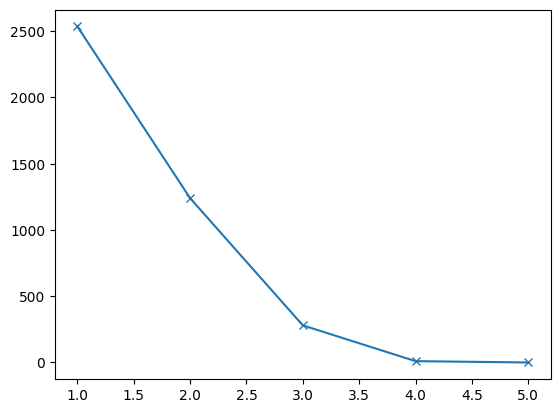

In [53]:
print(X.flatten())
print(KMeans(n_clusters=3, random_state=42).fit_predict(X))
plt.plot(distortions.keys(), distortions.values(), marker="x")

In [44]:
(distortions[2] - distortions[3]) / distortions[2]

0.7741935483870968

In [39]:
ks = sorted(distortions.keys())
distortion_values = [distortions[k] for k in ks]

# Calculate % drops
percentage_drops = []
for i in range(1, len(distortion_values)):
    drop = (distortion_values[i-1] - distortion_values[i]) / distortion_values[i-1]
    percentage_drops.append(drop)

percentage_drops

[0.5110410094637224, 0.7741935483870968, 0.9642857142857143, 1.0]

In [ ]:
# Find where the drop starts becoming small
elbow_k = None
for i, drop in enumerate(percentage_drops):
    if drop < threshold:
        elbow_k = ks[i]
        break

if elbow_k is None:
    elbow_k = 1

In [11]:
final_df[(final_df["Product_Category"] == "Mosquito Net")].groupby("Size")["UnitPrice"].apply(lambda x: set(x))

Size
6x10                             {300}
6x4               {160, 140, 120, 150}
6x6     {160, 200, 170, 340, 180, 150}
6x8          {200, 150, 250, 220, 190}
Name: UnitPrice, dtype: object

In [22]:
final_df[(final_df["Product_Category"] == "T-Shirt") & (final_df["Product_Details"] == "Collar Polyester")]["UnitPrice"].value_counts()

UnitPrice
180    1
250    1
280    1
Name: count, dtype: int64

In [28]:
final_df[
    (final_df["Product_Category"] == "Underwear") &
    (final_df["Product_Details"] == "Long Trunk") &
    (final_df["Size"] == "90") &
    (final_df["Product_Company"] == "Stant")
]["UnitPrice"].value_counts()

UnitPrice
100    4
90     2
Name: count, dtype: int64